# Lightweight conditional distribution for LLG constant weights

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds = torch.distributions.Uniform(0,1)
dz1 = torch.distributions.Uniform(0,1)
dz2 = torch.distributions.Uniform(0,1)

dv1 = torch.distributions.Uniform(0,1)
dv2 = torch.distributions.Uniform(0,1)

We have

$$v_1 = (1-w)z_1 + ws$$
$$v_2 = (1-w)z_2 + ws$$

and thus

$$ v_2 = (1-w)(z_2 - z_1) + v_1 $$ and the conditional

$$v_2|v_1 = (1-w)(z_2|v_1 - z_1|v_1) + v_1$$ but $z_2$ is (conditionally) independent from $v_1$.

To sample $v_2|v_1$ we thus only need the distribution of $z_1|v_1$. To find this, we can use Bayes thm and get

$$
f_{Z_1|V_1=v_1}(z_1) \propto f_{V_1|Z_1}(v_1)f_{Z_1}(z_1) = f_{V_1|Z_1}(v_1) \mathbb{1}_{[0,1]}(z_1)
$$

We have
$$Z_1 = \frac{V_1 - wS}{1-w} $$

and, as $Z_1 \perp S$, the value of $V_1|Z_1$ is determined by the possible value of the uniformly distributed $S$ and we get
$$f_{V_1|Z_1=z_1}(v_1) = \begin{cases} 0 & v_1 < (1-w)z_1 \\ \frac{1}{w} & (1-w)z_1 < v_1 < (1-w)z_1 + w \\ 0 & v_1 > (1-w)z+1 + w\end{cases}$$

i.e. $$V_1|Z_1 \sim \mathcal U[(1-w)z_1 , (1-w)z_1 + w]$$

Rewriting the boundaried in terms of $z_1$ for the left hand side of the Bayesian equation, we further have

$$Z_1|V_1=v_1 \sim \mathcal U\left[\frac{v_1-w}{1-w} , \frac{v_1}{1-w}\right]$$

Possibly, we need to cap this at $[0,1]$ (correponds to indicator in $f_{Z_1}$ above.)

For $w=1$, i.e. $\gamma=1$, we have $V_1 = V_2$, thus the value of $Z_2 - Z_1$ doesn't matter and can be disregarded.

Empirical Validation

In [3]:
def weight(gamma):
    if gamma==0.5:
        return 0.5
    return (gamma - np.sqrt(gamma*(1-gamma))) / (2*gamma - 1)

def d_v1_given_z1(gamma, z1):
    w = weight(gamma)
    return torch.distributions.Uniform((z1 *(1-w)), z1*(1-w) + w)


# given z1 and v1 are both std-uniform, we get by Bayes theorem:
def d_z1_given_v1(gamma,v1):
    # degenerate case -- z1 doesn't matter, but we still need the interface
    if gamma==1.0:
        return torch.distributions.Uniform(0,1)
    
    w= weight(gamma)
    return torch.distributions.Uniform(max(0,(v1 - w)/(1-w)), min(1,v1/(1-w)))

def draw_conditional_v2(n, gamma, v1):
    w = weight(gamma)
    # z1 is conditionally independent from v1
    z2 = dz2.sample((n,))
    conditional_dist_z1 = d_z1_given_v1(gamma, v1)
    z1 = conditional_dist_z1.sample((n,))
    v2 = (1-w)*(z2 - z1) + v1
    return v2  

def draw_joint_observations(n,gamma):
    w = weight(gamma)
    z1 = dz1.sample((n,))
    z2 = dz2.sample((n,))
    s = ds.sample((n,))

    v1 = (1-w)*z1 + w*s
    v2 = (1-w)*z2 + w*s
    
    return v1,v2
  
def conditional_slice(v1, v2, v1_value, delta=0.01):
    "return all v2 with matching v1 in v1_value +- delta"
    indices = torch.logical_and(v1 > v1_value - delta, v1 < v1_value + delta)
    return v2[indices]
    

Plot Histograms of slice-of joined vs sampled from conditional for all $\gamma$, $v_1$

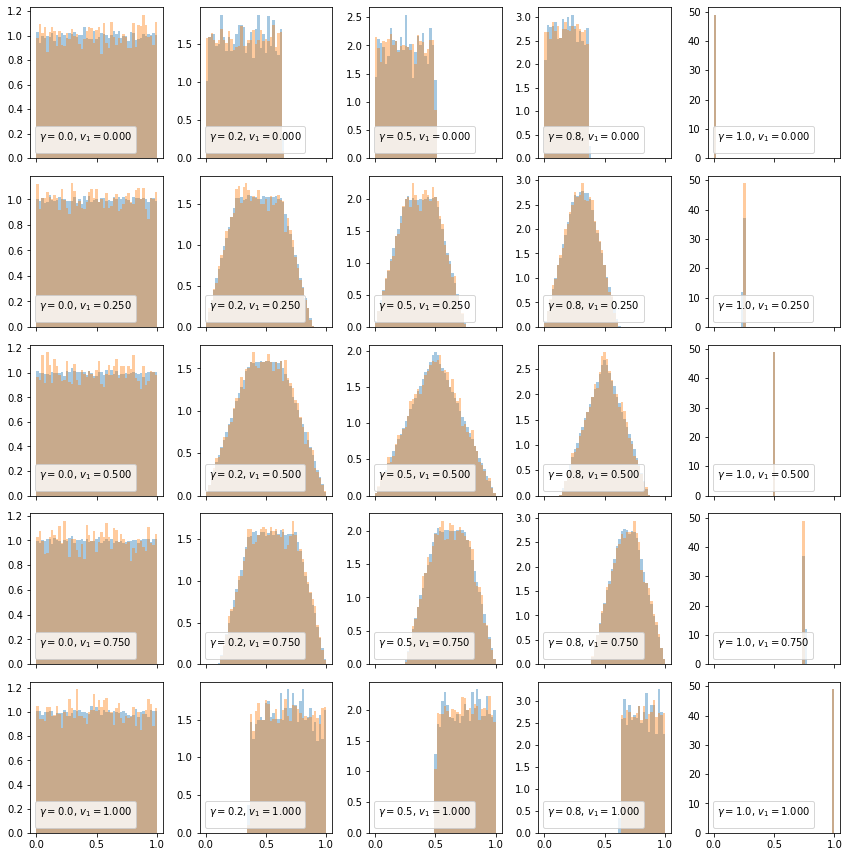

In [4]:
# all histograms
n_samples_joint = 10000000
n_samples_cond = int(n_samples_joint/1000)

n_gammas = 4
n_v1_vals = 4
gammas = [i/n_gammas for i in range(n_gammas+1)]
v1_vals = [i/n_v1_vals for i in range(n_v1_vals+1)]

bins = np.linspace(0, 1, 50)

fig, axs = plt.subplots(
    nrows=n_v1_vals+1, ncols=n_gammas+1,
    sharex=True, sharey=False,
    figsize=(12, 12)
)

for col, gamma in enumerate(gammas):
    v1, v2 = draw_joint_observations(n_samples_joint,gamma)
    
    for row, v1_val in enumerate(v1_vals):
        ax = axs[row, col]
        
        v2_slice = conditional_slice(v1,v2, v1_val)
        v2_cond = draw_conditional_v2(n_samples_cond, gamma, v1_val)
        
        ax.hist(v2_slice.numpy(), bins, alpha=0.4, label='slice of joint',density=True)
        ax.hist(v2_cond.numpy(), bins, alpha=0.4, label='conditional sample', density=True)
        ax.legend([], loc='lower left', title=f'$\gamma = {gamma:.1f}$, $v_1 = {v1_val:.3f}$')
    
        
plt.tight_layout()
plt.show()

Conclusion:

![gif](https://media.giphy.com/media/S44sdY3OzruLOGLikk/giphy.gif)